In [42]:
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display
import os

In [28]:
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("groq_api")

#Model Initialization:
llama = ChatGroq(
    model = "llama-3.1-8b-instant",
    temperature=0,
)
llama.profile

{'max_input_tokens': 131072,
 'max_output_tokens': 8192,
 'image_inputs': False,
 'audio_inputs': False,
 'video_inputs': False,
 'image_outputs': False,
 'audio_outputs': False,
 'video_outputs': False,
 'reasoning_output': False,
 'tool_calling': True}

In [29]:
def multiply(a:int,b:int)->int:
    """Multiply a and b and return the result.
    Args:
        a: first int
        b: second int
    """
    return a*b
def divide(a:int,b:int)->int:
    """Divide a and b and return the result.
    Args:
        a: first int
        b: second int
    """
    return a / b
def add(a:int,b:int)->int:
    """Add a and b and return the result.
    Args:
        a: first int
        b: second int
    """
    return a+b
def subract(a:int,b:int)->int:
    """Subtract a and b and return the result.
    Args:
        a: first int
        b: second int
    """
    return a-b

llm_with_tools = llama.bind_tools([add,subract,multiply,divide])

In [64]:
def assistant(state:MessagesState):
    system_prompt = SystemMessage("You are helpful math assistant help the user to perform arithmetic operations")
    return {"messages" : llm_with_tools.invoke([system_prompt]+state['messages']) }

In [65]:
builder = StateGraph(MessagesState)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode([add,subract,multiply,divide]))

builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")
react_graph = builder.compile()

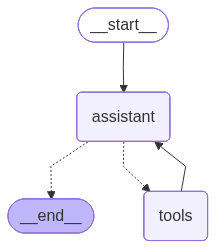

In [66]:
display(react_graph)

In [67]:
messages = [
    HumanMessage("Add 79 and 1900. Multiply the added result with 458. Finally Divide the multiplied result by 85")
]
messages = react_graph.invoke({"messages" : messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 79 and 1900. Multiply the added result with 458. Finally Divide the multiplied result by 85
================================== Ai Message ==================================
Tool Calls:
  add (d38tbw4g7)
 Call ID: d38tbw4g7
  Args:
    a: 79
    b: 1900
  multiply (7m5zreagm)
 Call ID: 7m5zreagm
  Args:
    a: 1979
    b: 458
  divide (7fn3nd7dv)
 Call ID: 7fn3nd7dv
  Args:
    a: 906502
    b: 85
================================= Tool Message =================================
Name: add

1979
================================= Tool Message =================================
Name: multiply

906382
================================= Tool Message =================================
Name: divide

10664.729411764705
================================== Ai Message ==================================

The final result is 10664.729411764705.


In [36]:
messages = [
    HumanMessage("Add 79 and 1900.")
]
messages = react_graph.invoke({"messages" : messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

You are helpful math assistant help the user to perform arithmetic operations
================================ Human Message =================================

Add 79 and 1900.
================================== Ai Message ==================================
Tool Calls:
  add (rnkxfk3rj)
 Call ID: rnkxfk3rj
  Args:
    a: 79
    b: 1900
================================= Tool Message =================================
Name: add

1979
================================== Ai Message ==================================

The result of the addition is 1979.


In [44]:
memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)
config = {"configurable" : {"thread_id":1}}
messages = [HumanMessage("Add 79 and 1900.")]
messages = react_graph.invoke({"messages" : messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

You are helpful math assistant help the user to perform arithmetic operations
================================ Human Message =================================

Add 79 and 1900.
================================== Ai Message ==================================
Tool Calls:
  add (0hxxycapv)
 Call ID: 0hxxycapv
  Args:
    a: 79
    b: 1900
================================= Tool Message =================================
Name: add

1979
================================== Ai Message ==================================

The result of the addition is 1979.


In [45]:
messages = [HumanMessage("Add by 10.")]
messages = react_graph.invoke({"messages" : messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

You are helpful math assistant help the user to perform arithmetic operations
================================ Human Message =================================

Add 79 and 1900.
================================== Ai Message ==================================
Tool Calls:
  add (0hxxycapv)
 Call ID: 0hxxycapv
  Args:
    a: 79
    b: 1900
================================= Tool Message =================================
Name: add

1979
================================== Ai Message ==================================

The result of the addition is 1979.
================================ System Message ================================

You are helpful math assistant help the user to perform arithmetic operations
================================ Human Message =================================

Add by 10.
================================== Ai Message ==================================

I think you meant to say "Add 

In [57]:
import sqlite3
import os
import urllib.request

os.makedirs("state_db", exist_ok=True)

url = "https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db"
path = "state_db/example.db"

if not os.path.exists(path):
    urllib.request.urlretrieve(url, path)
    print("Downloaded example.db")
else:
    print("example.db already exists")


example.db already exists


In [60]:
conn = sqlite3.connect(path,check_same_thread=False)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables")
for table in tables:
    print(table[0])

Tables
checkpoints
writes


In [62]:
# Fetch first 5 rows
table_name = "checkpoints"
cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
rows = cursor.fetchall()

print(f"\nSample data from {table_name}:")
for row in rows:
    print(row)


Sample data from checkpoints:
('1', '', '1ef64b22-3155-65d8-bfff-cb35a53ab872', None, 'json', b'{"v": 1, "ts": "2024-08-27T20:22:52.733166+00:00", "id": "1ef64b22-3155-65d8-bfff-cb35a53ab872", "channel_values": {"messages": [], "__start__": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m Lance", "type": "human"}}]}}, "channel_versions": {"__start__": "00000000000000000000000000000001.761a8c54329ca020d4813f3f8164401b"}, "versions_seen": {"__input__": {}}, "pending_sends": [], "current_tasks": {}}', b'{"source": "input", "writes": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m Lance", "type": "human"}}]}, "step": -1}')
('1', '', '1ef64b22-315d-6eae-8000-a235a23be95b', '1ef64b22-3155-65d8-bfff-cb35a53ab872', 'json', b'{"v": 1, "ts": "2024-08-27T20:22:52.736675+00:00", "id": "1ef64b22-315d-6eae-8000-a235a23be95

In [70]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)
graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="hi! I'm Gaja")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You've already introduced yourself as Gaja earlier.
================================== Ai Message ==================================

Gaja.
================================== Ai Message ==================================

You're a 49ers fan!


In [71]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='086e80ce-8bd0-4dee-b13c-f47160d6755f'), AIMessage(content="Hello Lance! You've already introduced yourself, but it's nice to greet you again. Is there something specific you'd like to talk about? Perhaps you'd like to continue our conversation about the 49ers, or is there another topic you're interested in discussing?", additional_kwargs={}, response_metadata={'id': 'msg_01AkDF6AH7LMp2YDDD9jQkEC', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 197, 'output_tokens': 58}}, id='run-7f8af5e1-5248-4ccd-ab46-87580422f0d6-0', usage_metadata={'input_tokens': 197, 'output_tokens': 58, 'total_tokens': 255}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e33f42ee-cdb0-45ec-b100-54dcd4c82e71'), AIMessage(content="Your name is Lance. You've introduced yourself twice durin